# This is the file that will create the library of interpolated PSFs and save them in an h5 files using pytables.

### Begin by importing the necessary modules and functions.

In [12]:
import astropy.io.fits as fits
import astropy.units as u
import os
import numpy as np
import time
from pathlib import Path
home_path = Path(os.getcwd())
from tables import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})

from importlib import reload
import misc_functions
reload(misc_functions)
from misc_functions import load_interpped_A, closest_PSF, run_sim_forloop, run_sim_standard
from misc_functions import setup_ipac_interpfun, setup_prop_interpfun, setup_prop_dm_interpfun

lambda0_m = 575e-9
D = 2.3631
mas_per_lamD = lambda0_m * 360.0 * 3600.0 / (2 * np.pi * D) * 1000    # mas per lambda0/D
as_per_lamD = mas_per_lamD/1000

nzodi = 256
nprop = 256
nipac = 128

ipac_pxscl_lamD = 0.2
prop_pxscl_lamD = 0.1

ipac_pxscl_mas = ipac_pxscl_lamD*mas_per_lamD
prop_pxscl_mas = prop_pxscl_lamD*mas_per_lamD

## Setup the interpolating function desired using the functions provided in the misc_functions module. Choose which interpolation method is to be used, the default is nearest.

In [13]:
ipac_interpfun = setup_ipac_interpfun(method='linear')

## Test the interpolating function by using the closest_PSF function along with an x and y offset to see if a PSF of correct dimensions is interpolated for.

Generating interpolated PSF for x-offset of 300.00 marcsec and y-offset of 200.00 marcsec.


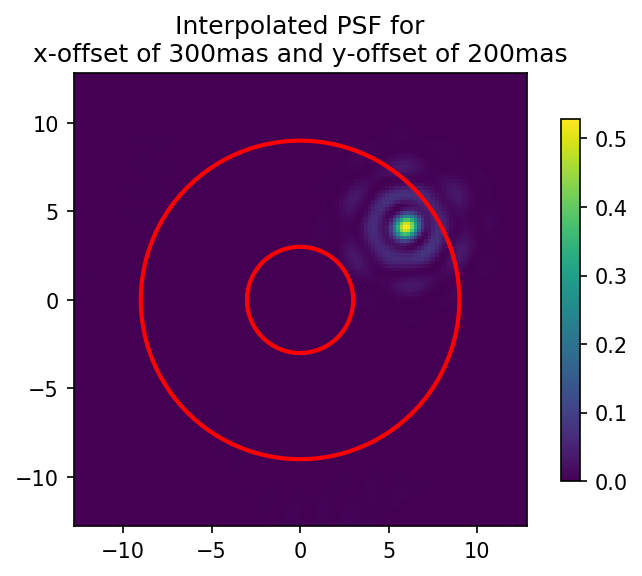

In [25]:
xoff = 300*u.milliarcsecond
yoff = 200*u.milliarcsecond
print('Generating interpolated PSF for x-offset of {:.2f} and y-offset of {:.2f}.'.format(xoff,yoff))
ipsf = closest_PSF(xoff,yoff,
                 ipac_interpfun,
                 nipac)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=150)

exmax = (nipac/2)*ipac_pxscl_lamD # define extent in lamD
exmin = -exmax
extent = [exmin,exmax,exmin,exmax]

im = ax.imshow(ipsf, cmap=plt.get_cmap('viridis'), extent=extent)
circ_in = Circle((0,0),3,edgecolor='red', facecolor='none',lw=2)
circ_out = Circle((0,0),9,edgecolor='red', facecolor='none',lw=2)
ax.add_patch(circ_in)
ax.add_patch(circ_out)
ax.set_title('Interpolated PSF for\nx-offset of {:.0f}mas and y-offset of {:.0f}mas'.format(xoff.value,yoff.value), fontsize=12)
fig.colorbar(im, ax=ax, shrink=0.8)

## Setup the $x$ and $y$ values using the pixel scale from the header of exozodiacal scenes file.

In [11]:
zodi_fname = 'zodipic_icube_10pc03.529mas.fits'
zodi_path = home_path/'zodi_scenes'/zodi_fname
zodi_cube_header = fits.getheader(zodi_path)
zodi_pxscl = zodi_cube_header['PIXELSCL']*u.arcsec # pixel scale is 3.529

xpix,ypix = np.meshgrid(np.arange(-nzodi/2,nzodi/2),np.arange(-nzodi/2,nzodi/2)) # 256by256 grid
xzodi = (xpix+.5).flatten()*zodi_pxscl
yzodi = (ypix+.5).flatten()*zodi_pxscl

## Setup the class that will contain the array objects. Choose the size of the array in the class based on which interpolating function is being used, if an IPAC interpolating function is being used then choose $n_{ipac}$, otherwise use $n_{prop}.$

In [11]:
n = nipac
class Library(IsDescription):    
    array = Float64Col(shape = (n**2))

## Initialize the h5 file using pytables and then use the closest_PSF function to create the interpolated PSFs for the $x$ and $y$ offsets of the pixels in the exozodiacal scene.

In [10]:
fname = "/groups/douglase/Interpped_PSFs/interpped_CGI_HLC_ipac_3529_linear.h5" # make the filename
h5file = open_file(fname, mode="w", title="Interpolated HLC PSFs") # open/initalize the file

table_where = '/' # where the group will created from the current group, '/' is the root group
table_name = 'interpolated_psfs' # name of the table to be created

table = h5file.create_table(table_where, table_name, Library, 'Interpolated Library',expectedrows = nzodi*nzodi)
print(h5file) # check the h5files data

In [15]:
numrows = nzodi*nzodi

start=time.time()
library = table.row # assign a variable to point to the table row
for i in range(numrows):
    ipsf = closest_PSF(x[i], y[i], ipac_interpfun, nipac)
    
    library['array'] = ipsf.flatten() # assign the flattened psf to the row
    library.append() # add the psf to the rows

table.flush()
end=time.time()
print(end-start)

h5f.close() # close the h5 file

334.2463879585266
